# Data Windowing & Creating Baselines for Deep Learning

#### Loading Libraries

In [1]:
# Numerical Computing
import numpy as np
# Data Manipulation
import pandas as pd
# Data manipulation
import datetime
# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Data Scalation
from sklearn.preprocessing import MinMaxScaler

# Deep Learning
import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

# Warnings
import warnings

In [37]:
from tensorflow.keras.optimizers import Adam
# Cambia esta línea
# from tensorflow.keras.optimizers import Adam
# Por esta
from tensorflow.keras.optimizers.legacy import Adam

In [38]:
warnings.filterwarnings('ignore')

##### Visualization Set Up

In [39]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = True

In [40]:
print(tf.__version__)

2.15.0


In [41]:
# Numerical & Tensorflow Setting Seeds
tf.random.set_seed(42)
np.random.seed(42)

#### Loading Data

In [42]:
train_df = pd.read_csv('/Users/isisromero/desktop/time_series/preprocessed/train.csv', index_col=0)
val_df = pd.read_csv('/Users/isisromero/desktop/time_series/preprocessed/val.csv', index_col=0)
test_df = pd.read_csv('/Users/isisromero/desktop/time_series/preprocessed/test.csv', index_col=0)

print(train_df.shape, val_df.shape, test_df.shape)

(12285, 5) (3510, 5) (1756, 5)


## Creating Data Windows

#### How Deep Learning Models are Trained for Time Series forecasting

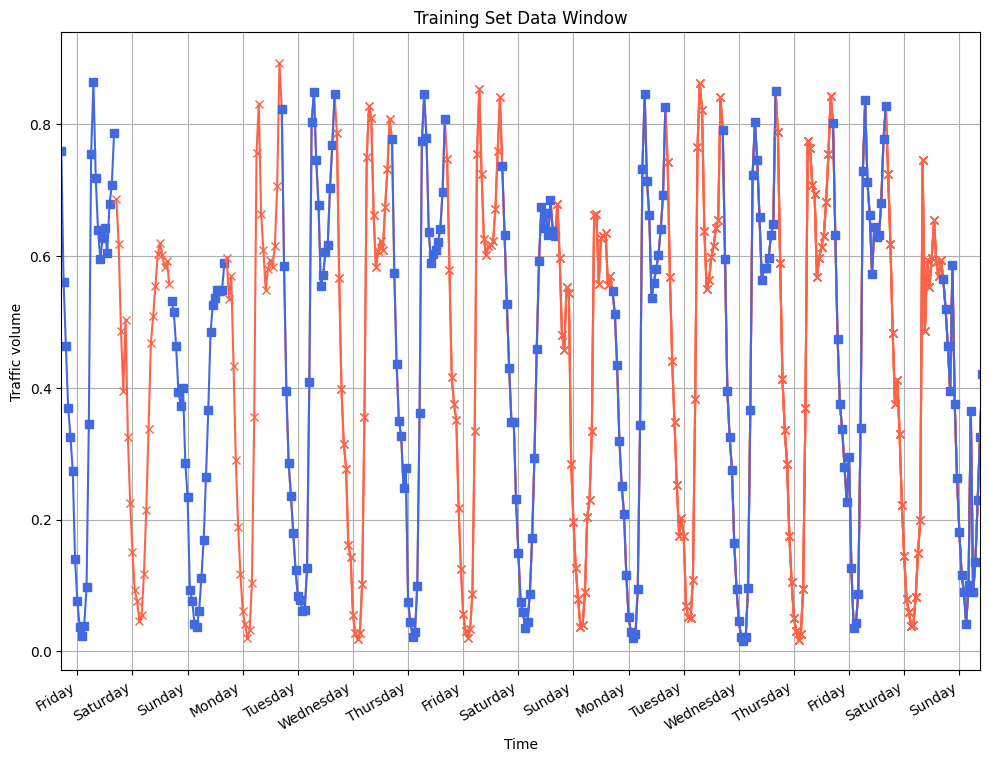

In [43]:
fig, ax = plt.subplots()

for n in range(0,17,2):
    start = 24*n
    stop = 24*(n+1)
    ax.plot(train_df.traffic_volume[start:stop], marker='s', color='royalblue', label='input')
    ax.plot(train_df.traffic_volume[stop:2*stop], marker='x', color='tomato', label='label')
ax.set_xlabel('Time')
ax.set_ylabel('Traffic volume')

plt.xticks(np.arange(7, 400, 24), ['Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday',
                                   'Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday',
                                   'Friday', 'Saturday', 'Sunday'])
plt.xlim(0, 400)

fig.autofmt_xdate()
plt.tight_layout()
plt.title('Training Set Data Window')
plt.show()

#### Data Window Function

In [44]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

#### Appplying Baseline Models

##### Single-Step Baseline Model

In [45]:
# Single-Step Model as Baseline

# Invoking DataWindow class
single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['traffic_volume']) 
# Wide Window for Predictions
wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['traffic_volume'])

##### Baseline Class

In [46]:
class Baseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return inputs
        
        elif isinstance(self.label_index, list):
            tensors = []
            for index in self.label_index:
                result = inputs[:, :, index]
                result = result[:, :, tf.newaxis]
                tensors.append(result)
            return tf.concat(tensors, axis=-1)
        
        result = inputs[:, :, self.label_index]
        return result[:,:,tf.newaxis]

In [47]:
# Training set Name & Dictionary Index
column_indices = {name: i for i, name in enumerate(train_df.columns)}

# Passing Target Column Index
baseline_last = Baseline(label_index=column_indices['traffic_volume'])

# (MSE)for Prediction metric & (MAE)for Model Evaluation 
baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

##### Baseline Performance

In [48]:
# MAE Validation Set
val_performance = {}
# MAE Test Set
performance = {}

val_performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.val)
performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.test, verbose=0)

110/110 [==============================] - 0s 352us/step - loss: 0.0133 - mean_absolute_error: 0.0831


##### Single-Step Baseline Model Performance Visualization

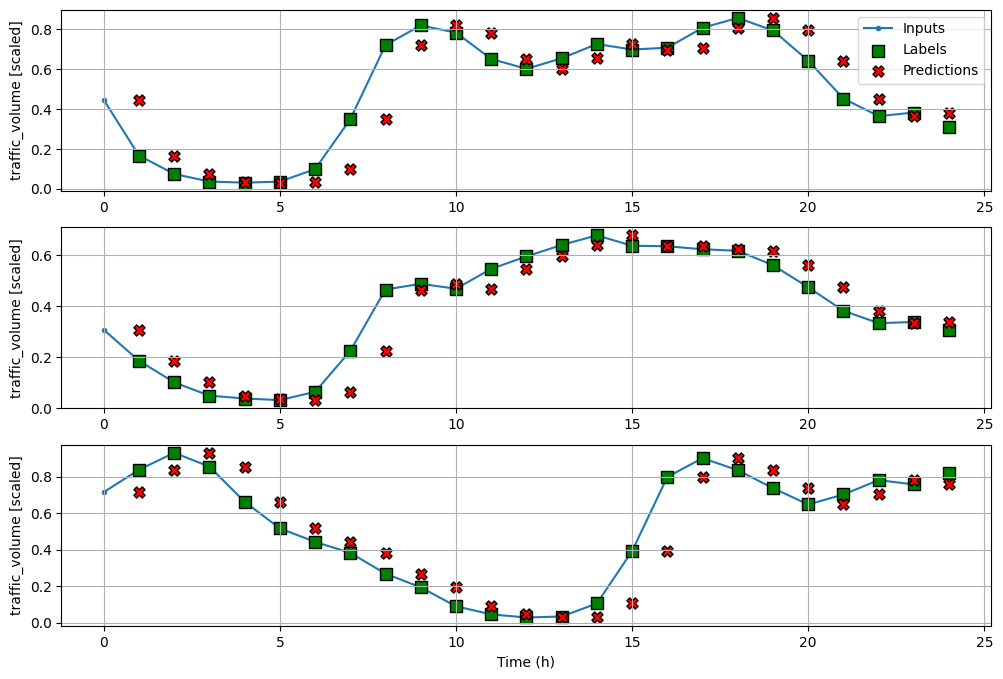

In [49]:
wide_window.plot(baseline_last)

##### MAE Test Set 

In [50]:
print(performance['Baseline - Last'][1])

0.08128400146961212


#### Multi-Step Baseline Models

##### Multi-Window (24 timesteps)

In [51]:
# Invoking DataWindow Class on 24 TimeSteps
multi_window = DataWindow(input_width=24, label_width=24, shift=24, label_columns=['traffic_volume'])

##### Predicting The Last Known Value

In [52]:
class MultiStepLastBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return tf.tile(inputs[:, -1:, :], [1, 24, 1])
        return tf.tile(inputs[:, -1:, self.label_index:], [1, 24, 1])

In [53]:
# Class Initialization
ms_baseline_last = MultiStepLastBaseline(label_index=column_indices['traffic_volume'])

# (MSE)for Prediction metric & (MAE)for Model Evaluation 
ms_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

ms_val_performance = {}
ms_performance = {}

ms_val_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.val)
ms_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.test, verbose=0)

109/109 [==============================] - 0s 351us/step - loss: 0.1875 - mean_absolute_error: 0.3522


##### Prediction Visualization

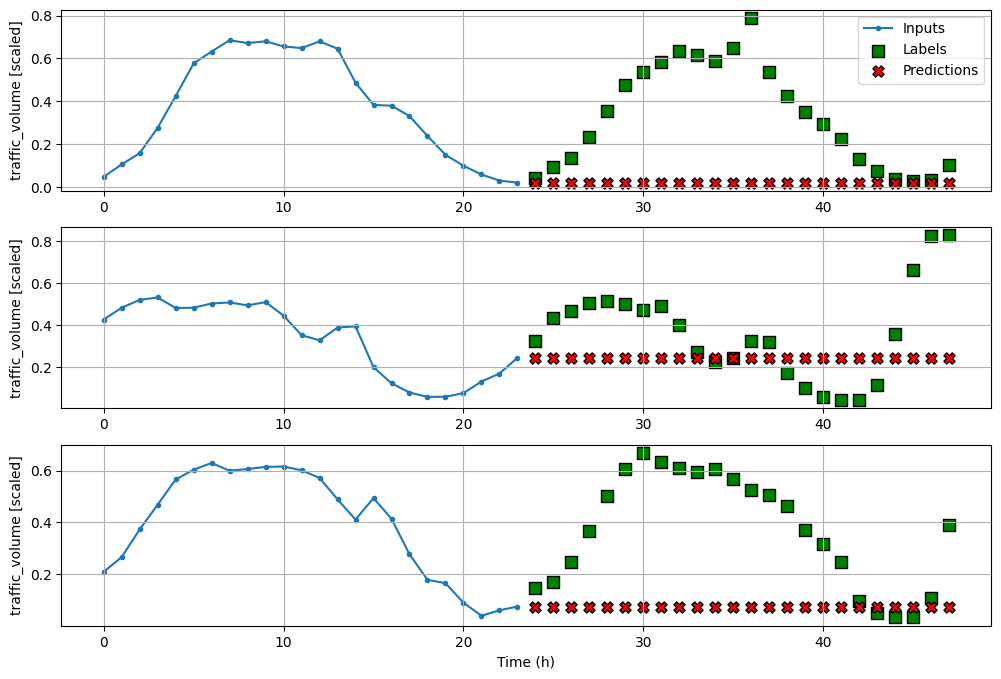

In [54]:
multi_window.plot(ms_baseline_last)

In [55]:
print(ms_performance['Baseline - Last'][1])

0.3473285734653473


##### Repeating The Input Sequence

In [56]:
class RepeatBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        return inputs[:, :, self.label_index:]

In [57]:
# Class Initialization
ms_baseline_repeat = RepeatBaseline(label_index=column_indices['traffic_volume'])

# (MSE)for Prediction metric & (MAE)for Model Evaluation 
ms_baseline_repeat.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

ms_val_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.val)
ms_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.test, verbose=0)

109/109 [==============================] - 0s 357us/step - loss: 0.1767 - mean_absolute_error: 0.3164


##### Prediction Visualization

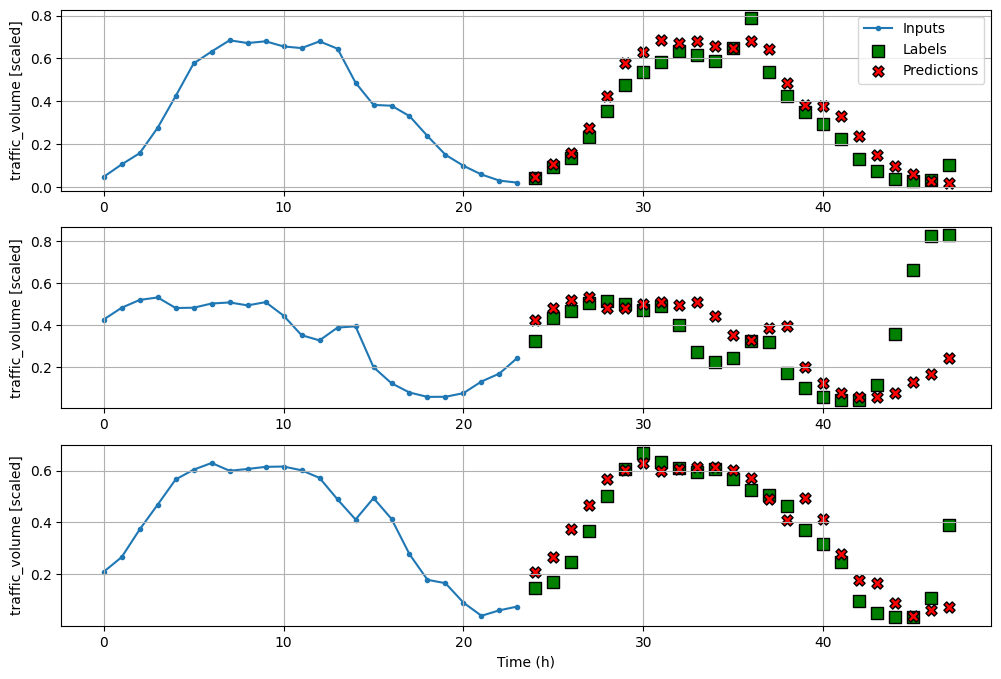

In [58]:
multi_window.plot(ms_baseline_repeat)

In [59]:
print(ms_performance['Baseline - Repeat'][1])

0.31225264072418213


#### Multi-Output Baseline Model

In [60]:
# Window for Training
mo_single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['temp','traffic_volume'])
# Window for Visualization
mo_wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['temp','traffic_volume'])

##### Checking: Traffic Volume & Temperature

In [61]:
print(column_indices['traffic_volume'])
print(column_indices['temp'])

2
0


In [62]:
# Class Initialization
mo_baseline_last = Baseline(label_index=[0, 2])

# (MSE)for Prediction metric & (MAE)for Model Evaluation 
mo_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

mo_val_performance = {}
mo_performance = {}

mo_val_performance['Baseline - Last'] = mo_baseline_last.evaluate(mo_wide_window.val)
mo_performance['Baseline - Last'] = mo_baseline_last.evaluate(mo_wide_window.test, verbose=0)

109/109 [==============================] - 0s 348us/step - loss: 0.0069 - mean_absolute_error: 0.0482


##### Model Prediction Visualization

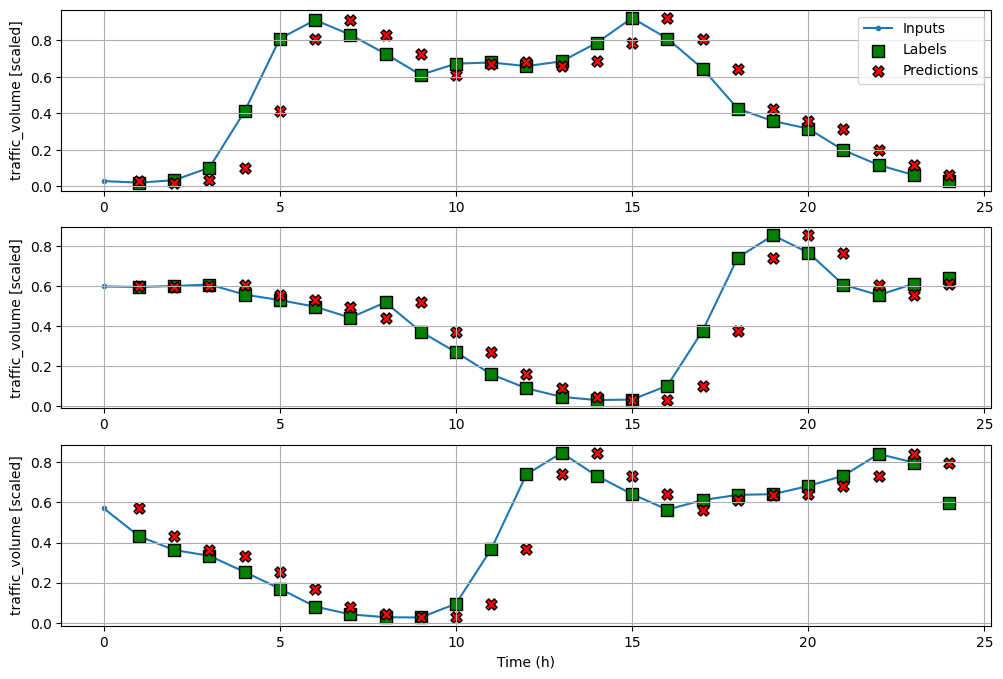

In [63]:
mo_wide_window.plot(mo_baseline_last)

##### Model Temperature Prediction

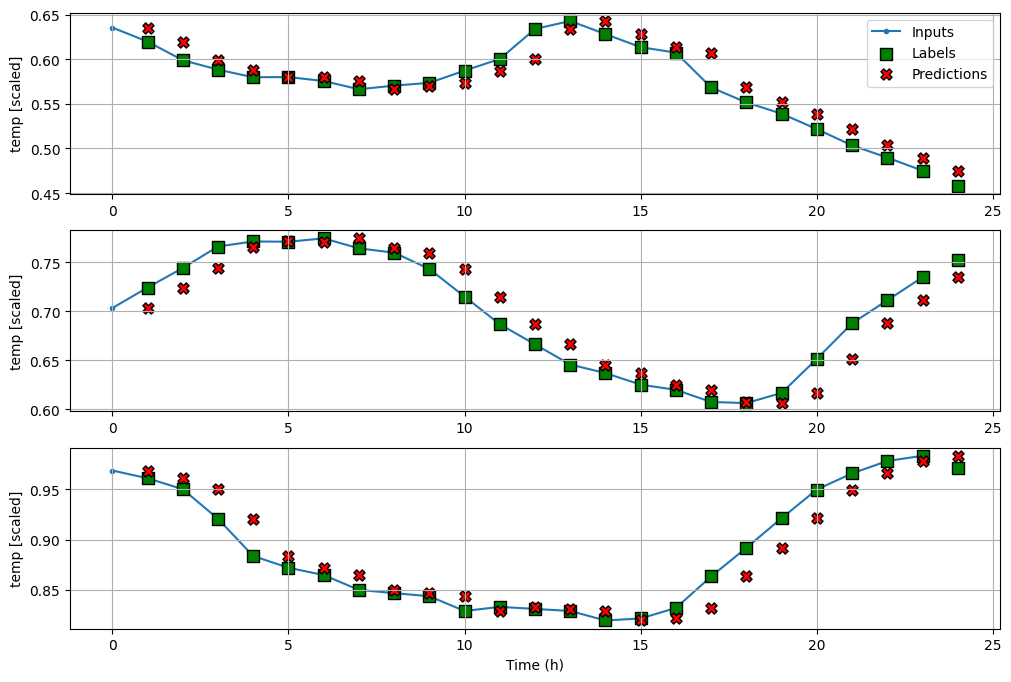

In [64]:
mo_wide_window.plot(model=mo_baseline_last, plot_col='temp')

In [65]:
print(mo_performance['Baseline - Last'][1])

0.04710666462779045


# Baby Steps with Deep Learning

#### Imprementing A Linear Model

##### Implementing a Single-Step Linear Model:  Defining a Compile & Fit Function

In [66]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

##### Setting The Network Up

In [67]:
# Building Model Up
linear = Sequential([
    Dense(units=1)
])

# Model Training
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/50
384/384 [==============================] - 0s 515us/step - loss: 0.2776 - mean_absolute_error: 0.4431 - val_loss: 0.1201 - val_mean_absolute_error: 0.3029
Epoch 2/50
384/384 [==============================] - 0s 391us/step - loss: 0.0730 - mean_absolute_error: 0.2324 - val_loss: 0.0419 - val_mean_absolute_error: 0.1709
Epoch 3/50
384/384 [==============================] - 0s 477us/step - loss: 0.0269 - mean_absolute_error: 0.1345 - val_loss: 0.0183 - val_mean_absolute_error: 0.1091
Epoch 4/50
384/384 [==============================] - 0s 445us/step - loss: 0.0145 - mean_absolute_error: 0.0939 - val_loss: 0.0130 - val_mean_absolute_error: 0.0892
Epoch 5/50
384/384 [==============================] - 0s 473us/step - loss: 0.0118 - mean_absolute_error: 0.0814 - val_loss: 0.0116 - val_mean_absolute_error: 0.0817
Epoch 6/50
384/384 [==============================] - 0s 407us/step - loss: 0.0109 - mean_absolute_error: 0.0767 - val_loss: 0.0109 - val_mean_absolute_error: 0.0768
Epoc

##### Checking Model Prediction Outcome

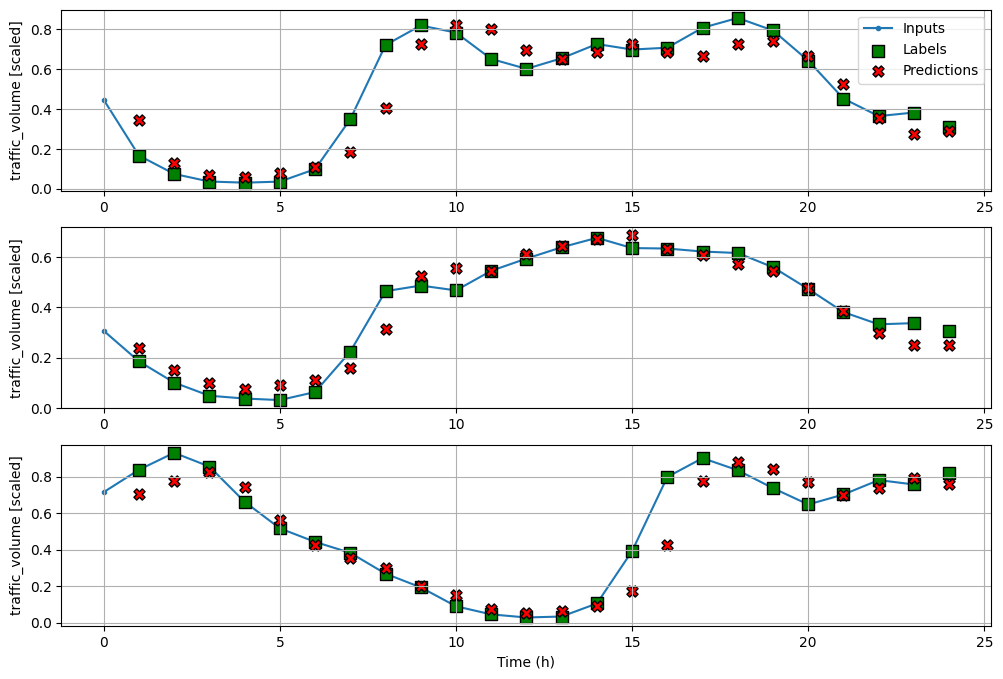

In [68]:
wide_window.plot(linear)

#### Implementing a Multi-Linear Step Model

In [69]:
# Multi-Linear Step Procedure

# Building Model Up
ms_linear = Sequential([
    Dense(1, kernel_initializer=tf.initializers.zeros)
])

# Model Training
history = compile_and_fit(ms_linear, multi_window)

ms_val_performance['Linear'] = ms_linear.evaluate(multi_window.val)
ms_performance['Linear'] = ms_linear.evaluate(multi_window.test, verbose=0)

Epoch 1/50
383/383 [==============================] - 0s 510us/step - loss: 0.0841 - mean_absolute_error: 0.2344 - val_loss: 0.0411 - val_mean_absolute_error: 0.1705
Epoch 2/50
383/383 [==============================] - 0s 445us/step - loss: 0.0268 - mean_absolute_error: 0.1277 - val_loss: 0.0244 - val_mean_absolute_error: 0.1192
Epoch 3/50
383/383 [==============================] - 0s 470us/step - loss: 0.0193 - mean_absolute_error: 0.1017 - val_loss: 0.0210 - val_mean_absolute_error: 0.1056
Epoch 4/50
383/383 [==============================] - 0s 414us/step - loss: 0.0177 - mean_absolute_error: 0.0955 - val_loss: 0.0196 - val_mean_absolute_error: 0.0999
Epoch 5/50
383/383 [==============================] - 0s 443us/step - loss: 0.0170 - mean_absolute_error: 0.0923 - val_loss: 0.0189 - val_mean_absolute_error: 0.0960
Epoch 6/50
383/383 [==============================] - 0s 432us/step - loss: 0.0166 - mean_absolute_error: 0.0899 - val_loss: 0.0185 - val_mean_absolute_error: 0.0933
Epoc

#### Implementing a Multi-Output Linear Model

In [70]:
# Building Model Up
mo_linear = Sequential([
    Dense(units=2)
])

# Model Training
history = compile_and_fit(mo_linear, mo_single_step_window)

mo_val_performance['Linear'] = mo_linear.evaluate(mo_single_step_window.val)
mo_performance['Linear'] = mo_linear.evaluate(mo_single_step_window.test, verbose=0)

Epoch 1/50
384/384 [==============================] - 0s 497us/step - loss: 0.1353 - mean_absolute_error: 0.2817 - val_loss: 0.0782 - val_mean_absolute_error: 0.2101
Epoch 2/50
384/384 [==============================] - 0s 409us/step - loss: 0.0513 - mean_absolute_error: 0.1717 - val_loss: 0.0327 - val_mean_absolute_error: 0.1373
Epoch 3/50
384/384 [==============================] - 0s 466us/step - loss: 0.0215 - mean_absolute_error: 0.1132 - val_loss: 0.0141 - val_mean_absolute_error: 0.0914
Epoch 4/50
384/384 [==============================] - 0s 445us/step - loss: 0.0103 - mean_absolute_error: 0.0772 - val_loss: 0.0076 - val_mean_absolute_error: 0.0641
Epoch 5/50
384/384 [==============================] - 0s 456us/step - loss: 0.0066 - mean_absolute_error: 0.0570 - val_loss: 0.0056 - val_mean_absolute_error: 0.0498
Epoch 6/50
384/384 [==============================] - 0s 428us/step - loss: 0.0056 - mean_absolute_error: 0.0473 - val_loss: 0.0050 - val_mean_absolute_error: 0.0439
Epoc

## More Complex Architecture: A Deep Neural Network

### Implementing Deep Neural Network

#### As a Single-Step Model

In [71]:
# Building Model Up
dense = Sequential([
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=1)
])

# Model Training
history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/50
384/384 [==============================] - 0s 685us/step - loss: 0.0177 - mean_absolute_error: 0.0833 - val_loss: 0.0055 - val_mean_absolute_error: 0.0548
Epoch 2/50
384/384 [==============================] - 0s 572us/step - loss: 0.0051 - mean_absolute_error: 0.0529 - val_loss: 0.0041 - val_mean_absolute_error: 0.0479
Epoch 3/50
384/384 [==============================] - 0s 548us/step - loss: 0.0042 - mean_absolute_error: 0.0482 - val_loss: 0.0034 - val_mean_absolute_error: 0.0428
Epoch 4/50
384/384 [==============================] - 0s 610us/step - loss: 0.0037 - mean_absolute_error: 0.0443 - val_loss: 0.0035 - val_mean_absolute_error: 0.0451
Epoch 5/50
384/384 [==============================] - 0s 603us/step - loss: 0.0033 - mean_absolute_error: 0.0422 - val_loss: 0.0029 - val_mean_absolute_error: 0.0403
Epoch 6/50
384/384 [==============================] - 0s 609us/step - loss: 0.0032 - mean_absolute_error: 0.0411 - val_loss: 0.0028 - val_mean_absolute_error: 0.0403
Epoc

##### Plotting Outcome

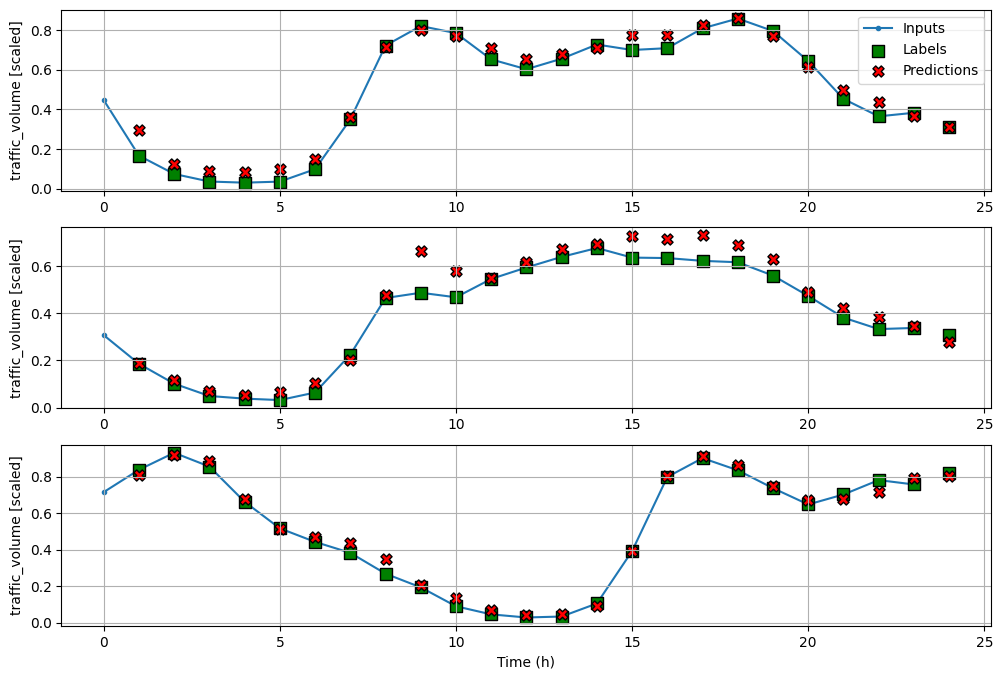

In [72]:
wide_window.plot(dense)

#### Contrasting Linear Model vs. DNN Performance

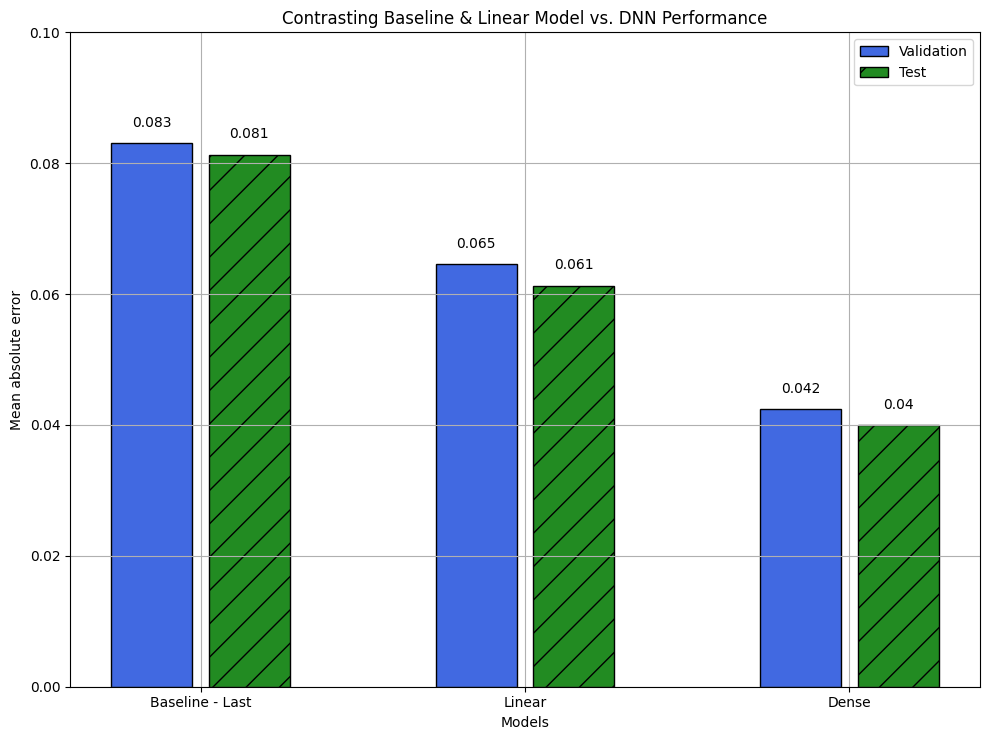

In [88]:
mae_val = [v[1] for v in val_performance.values()]
mae_test = [v[1] for v in performance.values()]

x = np.arange(len(performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='royalblue', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='forestgreen', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.1)
plt.xticks(ticks=x, labels=performance.keys())
plt.legend(loc='best')
plt.title('Contrasting Baseline & Linear Model vs. DNN Performance')
plt.tight_layout()

#### Implementing DNN as Multi-Step Model

In [81]:
# Building Model Up
ms_dense = Sequential([
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

# Model Training
history = compile_and_fit(ms_dense, multi_window)

ms_val_performance['Dense'] = ms_dense.evaluate(multi_window.val)
ms_performance['Dense'] = ms_dense.evaluate(multi_window.test, verbose=0)

Epoch 1/50
383/383 [==============================] - 0s 942us/step - loss: 0.0294 - mean_absolute_error: 0.1091 - val_loss: 0.0172 - val_mean_absolute_error: 0.0895
Epoch 2/50
383/383 [==============================] - 0s 849us/step - loss: 0.0141 - mean_absolute_error: 0.0784 - val_loss: 0.0157 - val_mean_absolute_error: 0.0845
Epoch 3/50
383/383 [==============================] - 0s 846us/step - loss: 0.0134 - mean_absolute_error: 0.0771 - val_loss: 0.0155 - val_mean_absolute_error: 0.0859
Epoch 4/50
383/383 [==============================] - 0s 874us/step - loss: 0.0132 - mean_absolute_error: 0.0765 - val_loss: 0.0148 - val_mean_absolute_error: 0.0826
Epoch 5/50
383/383 [==============================] - 0s 853us/step - loss: 0.0129 - mean_absolute_error: 0.0755 - val_loss: 0.0147 - val_mean_absolute_error: 0.0805
Epoch 6/50
383/383 [==============================] - 0s 880us/step - loss: 0.0128 - mean_absolute_error: 0.0750 - val_loss: 0.0146 - val_mean_absolute_error: 0.0812
Epoc

##### Contrasting Baseline & Linear Model vs. DNN Multi-Step Performance

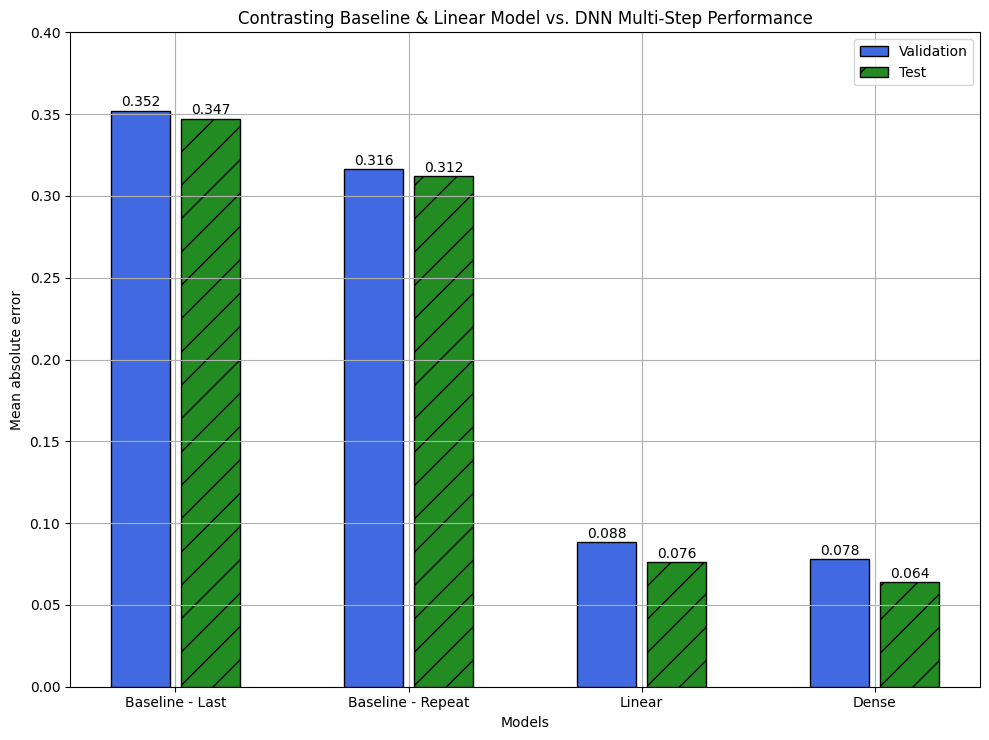

In [86]:
ms_mae_val = [v[1] for v in ms_val_performance.values()]
ms_mae_test = [v[1] for v in ms_performance.values()]

x = np.arange(len(ms_performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, ms_mae_val, width=0.25, color='royalblue', edgecolor='black', label='Validation')
ax.bar(x + 0.15, ms_mae_test, width=0.25, color='forestgreen', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(ms_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(ms_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.4)
plt.xticks(ticks=x, labels=ms_performance.keys())
plt.legend(loc='best')
plt.title('Contrasting Baseline & Linear Model vs. DNN Multi-Step Performance')
plt.tight_layout()

#### Implementing DNN as Multi-Output Model

In [89]:
# Building Model Up
mo_dense = Sequential([
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    # Forecasting 2 Targets
    Dense(units=2)
])

# Model Training
history = compile_and_fit(mo_dense, mo_single_step_window)

mo_val_performance['Dense'] = mo_dense.evaluate(mo_single_step_window.val)
mo_performance['Dense'] = mo_dense.evaluate(mo_single_step_window.test, verbose=0)

Epoch 1/50
384/384 [==============================] - 0s 941us/step - loss: 0.0127 - mean_absolute_error: 0.0655 - val_loss: 0.0029 - val_mean_absolute_error: 0.0336
Epoch 2/50
384/384 [==============================] - 0s 554us/step - loss: 0.0028 - mean_absolute_error: 0.0326 - val_loss: 0.0020 - val_mean_absolute_error: 0.0284
Epoch 3/50
384/384 [==============================] - 0s 555us/step - loss: 0.0024 - mean_absolute_error: 0.0295 - val_loss: 0.0019 - val_mean_absolute_error: 0.0272
Epoch 4/50
384/384 [==============================] - 0s 541us/step - loss: 0.0021 - mean_absolute_error: 0.0283 - val_loss: 0.0017 - val_mean_absolute_error: 0.0257
Epoch 5/50
384/384 [==============================] - 0s 584us/step - loss: 0.0020 - mean_absolute_error: 0.0272 - val_loss: 0.0015 - val_mean_absolute_error: 0.0241
Epoch 6/50
384/384 [==============================] - 0s 661us/step - loss: 0.0019 - mean_absolute_error: 0.0264 - val_loss: 0.0014 - val_mean_absolute_error: 0.0235
Epoc

##### Contrasting Multi-Output Model vs. DNN Performance

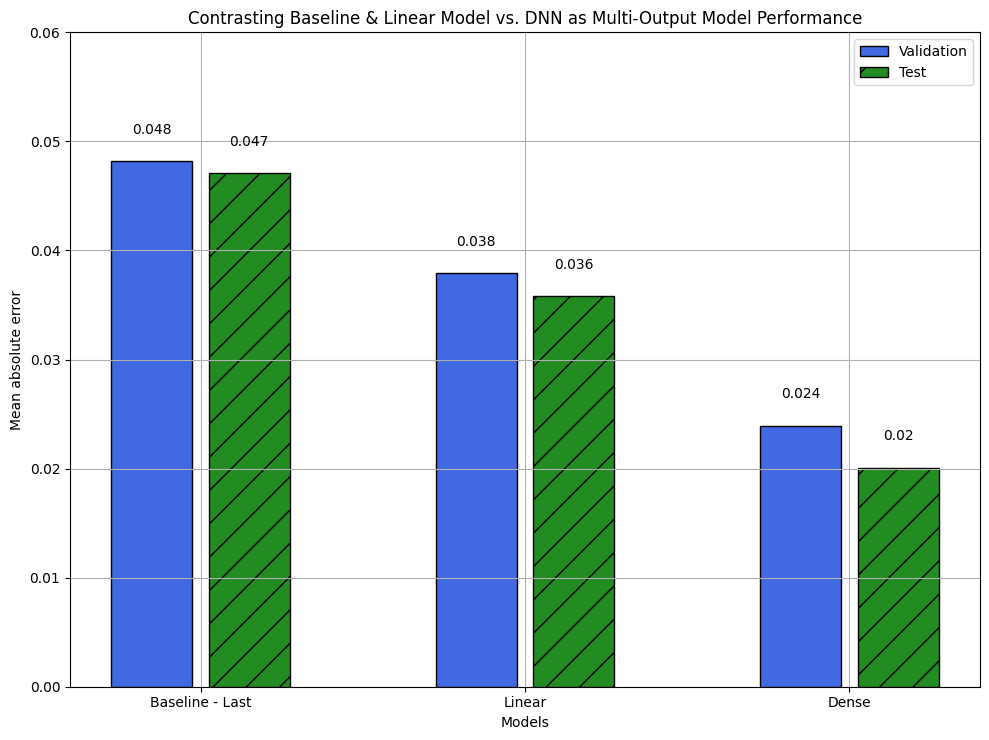

In [90]:
mo_mae_val = [v[1] for v in mo_val_performance.values()]
mo_mae_test = [v[1] for v in mo_performance.values()]

x = np.arange(len(mo_performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mo_mae_val, width=0.25, color='royalblue', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mo_mae_test, width=0.25, color='forestgreen', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mo_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mo_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.06)
plt.xticks(ticks=x, labels=mo_performance.keys())
plt.legend(loc='best')
plt.title('Contrasting Baseline & Linear Model vs. DNN as Multi-Output Model Performance')
plt.tight_layout()